# Forecasting of Grape Growing Seasons using ClimaX

This notebook finetunes ClimaX on the Global Wildfire Dataset and evaluates the results based on variety-specific heuristics.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%ls /content/drive/

Mounted at /content/drive
MyDrive/  Shareddrives/


In [ ]:
!pip install pytorch-lightning

### Clone ClimaX repo

In [ ]:
# if not yet cloned
# !git clone https://github.com/microsoft/ClimaX.git

In [ ]:
# to find modules
%cd /content/drive/Shareddrives/CS269-Project/code/
!cp -r ClimaX/src/climax /content/
!cp -r ClimaX/src/data_preprocessing /content/

/content/drive/Shareddrives/CS269-Project/code


### Load SeasFire data

In [ ]:
!pip install zarr
!pip install xarray[complete]
!pip install timm==0.6.12

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import xarray as xr
import zarr

In [ ]:
dataset=xr.open_zarr('/content/drive/Shareddrives/CS269-Project/data/seasfire.zarr')
dataset

<xarray.Dataset>
Dimensions:                         (latitude: 720, longitude: 1440, time: 966)
Coordinates:
  * latitude                        (latitude) float64 89.88 89.62 ... -89.88
  * longitude                       (longitude) float64 -179.9 -179.6 ... 179.9
  * time                            (time) datetime64[ns] 2001-01-01 ... 2021...
Data variables: (12/54)
    area                            (latitude, longitude) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    cams_co2fire                    (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    cams_frpfire                    (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    drought_code_max                (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    drought_code_mean               (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    fcci_ba                         (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ...                              ...
    t2m_max                         (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    t2m_mean                        (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    t2m_min                         (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    tp                              (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    vpd                             (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ws10                            (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
Attributes:
    crs:          EPSG:4326
    description:  The SeasFire Cube is a scientific datacube for seasonal fir...
    title:        SeasFire Cube: A Global Dataset for Seasonal Fire Modeling ...

In [ ]:
def select_spatio_temporal_data(dataset, initial_timestep, timesteps, step, latitude, longitude):
    '''
    Desc
    ----
    Method to select a subset of the cube.

    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    initial_timestep: int
        * value in the interval [0,965], where value represents the position of the date we want in the time array
        * shows from what 8-day period we want to extract the data
    timesteps: int
        * value in the interval [1,966]
        * shows for how many consecutive 8-days periods we want to extract the data
    latitude: int
        * vallue in the interval [0,719] where value represents the position of the latitude we want in the latitude array
        * if we want all the latitudes, we set the value = -1
    longitude: int
        * vallue in the interval [0,1439] where value represents the position of the longitude we want in the longitude array
        * if we want all the longitudes, we set the value = -1
    '''

    if(latitude == -1 and longitude == -1):
        return dataset.isel(time=slice(initial_timestep, initial_timestep+timesteps, step))

    return (dataset.isel(time=slice(initial_timestep, initial_timestep+timesteps))).sel(latitude=latitude, longitude=longitude)

In [ ]:
def select_variable_data(dataset, variable_name):
    '''
    Desc
    ----
    Method to select a particular variable (such as relaive humidity, windspeed, sst etc)
    from the DataCube.

    Args
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    variable name: string
        * name of the selected variable
    '''

    return dataset[variable_name]

## Adjust lead time and history

In [ ]:
batch_size = 2
num_workers = 8
patch_size = 14
na_lat = (24.396308, 49.384358)
na_long = (-125.000000, -66.934570)
ca_lat = (32.55, 37.42)
ca_long = (-121.75, -114.52)
img_size = [20, 29]
lat_range = slice(ca_lat[0], ca_lat[1], -1) # lat is backwards is datacube
long_range = slice(ca_long[0], ca_long[1])
data_split = (700, 90, 90)
time_history = 11
lead_time = 1   # num timesteps from last input to target time (units of 8 days)
vars = ['tp', 'ssrd', 't2m_max', 't2m_min', 't2m_mean', 'fwi_max', 'fwi_mean', 'rel_hum', 'ws10']

In [ ]:
# Reduce height/weight of a dataset to a desired image size
# Expects the DataArray format
# (currently necessary in our pipeline)
def reduce_dims(dataset, img_size):
  _, h, w = dataset.shape
  h_step = h // img_size[0]
  w_step = w // img_size[1]

  h_coord = [i * h_step for i in range(img_size[0])]
  w_coord = [i * w_step for i in range(img_size[1])]

  return dataset[:, h_coord, w_coord]

In [ ]:
from climax.utils.data_utils import BOUNDARIES

# Identify patches based on regional bounds
def get_region_info(region, bounds, lat, lon, patch_size):
    if region is not None:
      region = BOUNDARIES[region]
      lat_range = region['lat_range']
      lon_range = region['lon_range']
    else:
      lat_range = bounds[0]
      lon_range = bounds[1]
    lat = lat[::-1] # -90 to 90 from south (bottom) to north (top)
    h, w = len(lat), len(lon)
    lat_matrix = np.expand_dims(lat, axis=1).repeat(w, axis=1)
    lon_matrix = np.expand_dims(lon, axis=0).repeat(h, axis=0)
    valid_cells = (lat_matrix >= lat_range[0]) & (lat_matrix <= lat_range[1]) & (lon_matrix >= lon_range[0]) & (lon_matrix <= lon_range[1])
    h_ids, w_ids = np.nonzero(valid_cells)
    h_from, h_to = h_ids[0], h_ids[-1]
    w_from, w_to = w_ids[0], w_ids[-1]
    patch_idx = -1
    p = [patch_size,patch_size]  # Custom patch size: [height, width]
    p_h, p_w = p  # Unpacking patch height and width
    valid_patch_ids = []
    min_h, max_h = 1e5, -1e5
    min_w, max_w = 1e5, -1e5
    patch_idx = 0  # Initialize patch index

    for i in range(0, h, p_h):
        for j in range(0, w, p_w):
            patch_idx += 1
            if (i >= h_from) & (i + p_h - 1 <= h_to) & (j >= w_from) & (j + p_w - 1 <= w_to):
                valid_patch_ids.append(patch_idx)
                min_h = min(min_h, i)
                max_h = max(max_h, i + p_h - 1)
                min_w = min(min_w, j)
                max_w = max(max_w, j + p_w - 1)

    return {
        'patch_ids': valid_patch_ids,
        'min_h': min_h,
        'max_h': max_h,
        'min_w': min_w,
        'max_w': max_w
    }

In [ ]:
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader
from climax.regional_forecast.datamodule import collate_fn_regional
import torch
import copy
import json
import os

# Compute mean and std of variables
def get_stats(dataset, in_vars, out_vars):
    mean = {}
    sd = {}
    with open("/content/drive/Shareddrives/CS269-Project/data/seasfire_norm_mean.json", "r+") as fp_m:
      with open("/content/drive/Shareddrives/CS269-Project/data/seasfire_norm_sd.json", "r+") as fp_s:
        mean = json.load(fp_m)
        sd = json.load(fp_s)
        print(len(mean), len(sd))
        for vi in in_vars:
          if vi not in mean.keys():
            mean[vi] = dataset[vi].mean().values.item()
            sd[vi] = dataset[vi].std().values.item()
            print(vi)

        # Unused
        if len(out_vars) > 0:
          out_vals = {}
          for vo in out_vars:
            out_vals[vo] = np.array([])
          for year in range(2001, 2020):
            year_data = select_variable_data(dataset,
                                            in_vars
                                        ).sel(time=slice(str(year) + '-11-01', str(year + 1) + '-11-01')
                                        ).to_array("vars", ['time', 'latitude', 'longitude']
                                        ).transpose("time", "vars", ...
                                              )

            if 'stp' in out_vars and 'stp' not in mean.keys():
              np.append(out_vals['stp'], year_data.sel(vars='tp', time=slice(str(year + 1) + '-04-01', str(year + 1) + '-07-01')).sum().values.item())
            if 'htp' in out_vars and 'htp' not in mean.keys():
              np.append(out_vals['htp'], year_data.sel(vars='tp', time=slice(str(year + 1) + '-08-01', str(year + 1) + '-11-01')).sum().values.item())
            season = year_data.sel(vars='t2m_mean', time=slice(str(year + 1) + '-04-01', str(year + 1) + '-11-01'))
            if 'gst' in out_vars and 'gst' not in mean.keys():
              gst = season.sum().values.item()
              np.append(out_vals['gst'], gst / season.shape[0])
            if 'tdd' in out_vars and 'std' not in mean.keys():
              tdd = year_data.sel(vars='t2m_mean', time=slice(str(year + 1) + '-04-01', str(year + 1) + '-11-01')) * 8    # fill days btw measurement days
              np.append(out_vals['tdd'], tdd.sum().values.item() - (283.15 * 8 * season.shape[0]))    # (50F in K) * (* day freq) * (num measurements in season)

          for vo in out_vars:
            if vo not in mean.keys():
              mean[vo] = np.mean(out_vals[vo])
              sd[vo] = np.std(out_vals[vo])

    os.remove("/content/drive/Shareddrives/CS269-Project/data/seasfire_norm_mean.json")
    os.remove("/content/drive/Shareddrives/CS269-Project/data/seasfire_norm_sd.json")
    with open("/content/drive/Shareddrives/CS269-Project/data/seasfire_norm_mean.json", "w") as fp_m:
      json.dump(mean, fp_m)
    with open("/content/drive/Shareddrives/CS269-Project/data/seasfire_norm_sd.json", "w") as fp_s:
      json.dump(sd, fp_s)

    return (mean, sd)

def collate_fn(batch, region_info, in_vars, out_vars, lead_time):
    inp = torch.stack([batch[i][0] for i in range(len(batch))])   # want input to be long, lat, timestep, variable value
    inp = inp.half()
    out = torch.stack([batch[i][1][0] for i in range(len(batch))])   # want output to be variable value at same long/lat but next timestep
    out = out.half()
    lead_times = torch.from_numpy(np.full(len(batch), 192 * lead_time)).half()   # all lead times are 8 days (in hours...?)
    variables = in_vars
    out_variables = out_vars
    region_info = region_info
    return (
        inp,
        out,
        lead_times,
        [v for v in variables],
        [v for v in out_variables],
        region_info,
    )

class SeasfireDataModule(LightningDataModule):
    def __init__(self, dataset_input, vars, time_history=1, lead_time=1):
        super().__init__()
        self.dataset = dataset_input
        sample = select_spatio_temporal_data(
            select_variable_data(dataset, vars),
            0,
            1,
            1,
            latitude = lat_range,
            longitude = long_range
            )
        _, h, w = sample[vars[0]].shape

        # File paths for train, validation, and test datasets
        train_path = f'/content/drive/Shareddrives/CS269-Project/data/norm_train_dataset_h{time_history}_l{lead_time}.pt'
        val_path = f'/content/drive/Shareddrives/CS269-Project/data/norm_val_dataset_h{time_history}_l{lead_time}.pt'
        test_path = f'/content/drive/Shareddrives/CS269-Project/data/norm_test_dataset_h{time_history}_l{lead_time}.pt'
        if not os.path.exists(train_path):
            self.create_dataset(time_history, lead_time, h, w, vars)
        else:
          # Load datasets if they exist, else create and save them
          self.train_dataset = self.load_or_create_dataset(train_path, 'train', time_history, lead_time, h, w, vars)
          self.val_dataset = self.load_or_create_dataset(val_path, 'val', time_history, lead_time, h, w, vars)
          self.test_dataset = self.load_or_create_dataset(test_path, 'test', time_history, lead_time, h, w, vars)

        lat, lon = self.get_lat_lon()  # shifts longitude bounds to start at 0
        region_info = get_region_info(None, (ca_lat, (ca_long[0] + 180, ca_long[1] + 180)), lat, lon, patch_size)
        self.collate = lambda x: collate_fn(x, region_info, vars, vars, lead_time)
        self.data_mean = torch.tensor([5.5183, 20.6852, 294.7600, 285.3350, 289.7018, 45.5794, 33.7238, 48.7626, 3.0729], dtype=torch.float64)
        self.data_std = torch.tensor([13.6535, 7.1660, 8.5926, 6.9510, 7.5755, 27.4769, 22.2230, 21.1053, 2.0242], dtype=torch.float64)

    def create_dataset(self, time_history, lead_time, h, w, vars):
        print('create datasets for time history:', time_history, 'lead time:', lead_time, '\n for variables:', vars )
        train_in = np.empty((time_history, data_split[0], len(vars), h, w))
        train_out = np.empty((time_history, data_split[0], len(vars), h, w))

        for t in range(time_history):
          train_in[t] = select_spatio_temporal_data(
              select_variable_data(self.dataset, vars),
              0 + t,
              data_split[0],
              1,
              lat_range,
              long_range
            ).to_array("vars", ['time', 'latitude', 'longitude']
            ).transpose("time", "vars", ...
            ).to_numpy()
          train_out[t] = select_spatio_temporal_data(
              select_variable_data(self.dataset, vars),
              lead_time,
              data_split[0],
              time_history,
              lat_range,
              long_range
            ).to_array("vars", ['time', 'latitude', 'longitude']
            ).transpose("time", "vars", ...
            ).to_numpy()


        train_in_stack = torch.stack([torch.from_numpy(train_in[t].copy()) for t in range(time_history)], dim=1)
        train_out_stack = torch.stack([torch.from_numpy(train_out[t].copy()) for t in range(time_history)], dim=1)

        self.train_dataset = torch.stack((train_in_stack, train_out_stack), dim=1)
        val_in = np.empty((time_history, data_split[1], len(vars), h, w))
        val_out = np.empty((time_history, data_split[1], len(vars), h, w))

        for t in range(time_history):
          val_in[t] = select_spatio_temporal_data(
              select_variable_data(self.dataset, vars),
              data_split[0] + t,
              data_split[1],
              1,
              lat_range,
              long_range
            ).to_array("vars", ['time', 'latitude', 'longitude']
            ).transpose("time", "vars", ...
            ).to_numpy()
          val_out[t] = select_spatio_temporal_data(
              select_variable_data(self.dataset, vars),
              data_split[0] + lead_time,
              data_split[1],
              time_history,
              lat_range,
              long_range
            ).to_array("vars", ['time', 'latitude', 'longitude']
            ).transpose("time", "vars", ...
            ).to_numpy()

        val_in_stack = torch.stack([torch.from_numpy(val_in[t].copy()) for t in range(time_history)], dim=1)
        val_out_stack = torch.stack([torch.from_numpy(val_out[t].copy()) for t in range(time_history)], dim=1)

        self.val_dataset = torch.stack((val_in_stack, val_out_stack), dim=1)

        test_in = np.empty((time_history, data_split[2], len(vars), h, w))
        test_out = np.empty((time_history, data_split[2], len(vars), h, w))

        for t in range(time_history):
          test_in[t] = select_spatio_temporal_data(
              select_variable_data(self.dataset, vars),
              data_split[0] + data_split[1] + t,
              data_split[2],
              1,
              lat_range,
              long_range
            ).to_array("vars", ['time', 'latitude', 'longitude']
            ).transpose("time", "vars", ...
            ).to_numpy()
          test_out[t] = select_spatio_temporal_data(
              select_variable_data(self.dataset, vars),
              data_split[0] + data_split[1] + lead_time,
              data_split[2],
              time_history,
              lat_range,
              long_range
            ).to_array("vars", ['time', 'latitude', 'longitude']
            ).transpose("time", "vars", ...
            ).to_numpy()

        test_in_stack = torch.stack([torch.from_numpy(test_in[t].copy()) for t in range(time_history)], dim=1)
        test_out_stack = torch.stack([torch.from_numpy(test_out[t].copy()) for t in range(time_history)], dim=1)

        self.test_dataset = torch.stack((test_in_stack, test_out_stack), dim=1)

        self.save_dataset(self.train_dataset, f'/content/drive/Shareddrives/CS269-Project/data/unnorm_train_dataset_h{time_history}_l{lead_time}.pt')
        self.save_dataset(self.val_dataset, f'/content/drive/Shareddrives/CS269-Project/data/unnorm_val_dataset_h{time_history}_l{lead_time}.pt')
        self.save_dataset(self.test_dataset, f'/content/drive/Shareddrives/CS269-Project/data/unnorm_test_dataset_h{time_history}_l{lead_time}.pt')
        self.preprocess_data()
        self.save_dataset(self.train_dataset, f'/content/drive/Shareddrives/CS269-Project/data/norm_train_dataset_h{time_history}_l{lead_time}.pt')
        self.save_dataset(self.val_dataset, f'/content/drive/Shareddrives/CS269-Project/data/norm_val_dataset_h{time_history}_l{lead_time}.pt')
        self.save_dataset(self.test_dataset, f'/content/drive/Shareddrives/CS269-Project/data/norm_test_dataset_h{time_history}_l{lead_time}.pt')


    def save_dataset(self, dataset, filename):
        path = os.path.join('path/to/save', filename)
        torch.save(dataset, path)
        print(f"Dataset saved to {path}")

    def load_or_create_dataset(self, path, dataset_type, time_history, lead_time, h, w, vars):
        if os.path.exists(path):
            print(f"Loading {dataset_type} dataset from {path}")
            return torch.load(path)

    def get_lat_lon(self):
        coord = select_spatio_temporal_data(select_variable_data(dataset, vars[0]), 0, 966, 1, lat_range, long_range)
        lat = coord.coords['latitude'].to_numpy()
        lon = coord.coords['longitude'].to_numpy()
        if lon[0] < na_long[0] + 180:
          lon += 180
        return lat, lon

    def replace_nan_with_mean(self, data, mean):
        # Create a mask of NaN values
        nan_mask = torch.isnan(data)

        # Replace NaNs with the mean of each variable
        data[nan_mask] = mean[None, None, None, :, None, None].repeat(*data.shape[:-3], 1, *data.shape[-2:])[nan_mask]

        return data

    def normalize_data(self, data, mean, std):
        # Replace NaN values with the mean for each variable
        data_no_nan = self.replace_nan_with_mean(data, mean)

        # Normalize along the variable dimension (dim=3)
        normalized_data = (data_no_nan - mean[None, None, None, :, None, None]) / std[None, None, None, :, None, None]
        return normalized_data

    def get_norm_mean(self):
        # Reshape dataset to bring the variable dimension to the front
        reshaped_train_data = self.train_dataset.permute(3, 0, 1, 2, 4, 5).reshape(len(vars), -1)

        # Calculate mean and std for each variable across all other dimensions (ignoring NaNs)
        self.data_mean = torch.nanmean(reshaped_train_data, dim=1)
        self.data_std = self.nanstd(reshaped_train_data, dim=1)


    def preprocess_data(self):
        print('normalization started:')
        # Reshape dataset to bring the variable dimension to the front
        reshaped_train_data = self.train_dataset.permute(3, 0, 1, 2, 4, 5).reshape(len(vars), -1)

        # Calculate mean and std for each variable across all other dimensions (ignoring NaNs)
        self.data_mean = torch.nanmean(reshaped_train_data, dim=1)
        self.data_std = self.nanstd(reshaped_train_data, dim=1)

        # Normalize datasets
        self.train_dataset = self.normalize_data(self.train_dataset, self.data_mean, self.data_std)
        self.val_dataset = self.normalize_data(self.val_dataset, self.data_mean, self.data_std)
        self.test_dataset = self.normalize_data(self.test_dataset, self.data_mean, self.data_std)

    def nanstd(self, tensor, dim=None):
        """
        Compute the standard deviation while ignoring NaNs.
        """
        nan_mask = torch.isnan(tensor)
        masked_tensor = torch.where(nan_mask, torch.tensor(0.0, device=tensor.device), tensor)
        mean = torch.sum(masked_tensor, dim=dim) / (~nan_mask).sum(dim=dim)
        sq_diff = (masked_tensor - mean.unsqueeze(dim))**2
        var = torch.sum(torch.where(nan_mask, torch.tensor(0.0, device=tensor.device), sq_diff), dim=dim) / (~nan_mask).sum(dim=dim)
        return torch.sqrt(var)

    def reconstruct_data(self, normalized_data, nan_mask=None):
        """
        Reconstruct the original data from the normalized data.
        If nan_mask is provided, re-insert NaN values.
        """
        # Denormalize the data
        return normalized_data * self.data_std[None, None, None, :, None, None] + self.data_mean[None, None, None, :, None, None]

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=self.collate, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=self.collate, shuffle=False)

    def test_dataloader(self, batch_size=2):
        return DataLoader(self.test_dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=self.collate, shuffle=False)

In [ ]:
dataset=xr.open_zarr('/content/drive/Shareddrives/CS269-Project/data/seasfire.zarr')
datamodule = SeasfireDataModule(dataset_input=dataset, vars=vars, time_history=time_history, lead_time=lead_time)

Loading train dataset from /content/drive/Shareddrives/CS269-Project/data/norm_train_dataset_h11_l1.pt
Loading val dataset from /content/drive/Shareddrives/CS269-Project/data/norm_val_dataset_h11_l1.pt
Loading test dataset from /content/drive/Shareddrives/CS269-Project/data/norm_test_dataset_h11_l1.pt


In [ ]:
print(datamodule.data_mean, datamodule.data_std)

tensor([  5.5183,  20.6852, 294.7600, 285.3350, 289.7018,  45.5794,  33.7238,
         48.7626,   3.0729], dtype=torch.float64) tensor([13.6535,  7.1660,  8.5926,  6.9510,  7.5755, 27.4769, 22.2230, 21.1053,
         2.0242], dtype=torch.float64)


In [ ]:
torch.isnan(datamodule.train_dataset).any()

tensor(False)

In [ ]:
from climax.arch import ClimaX
import torch.nn as nn
from climax.utils.pos_embed import get_1d_sincos_pos_embed_from_grid

class RegionalClimaXCustom(ClimaX):
    def __init__(self, default_vars, time_history=1, img_size=..., patch_size=2, embed_dim=1024, depth=8, decoder_depth=2, num_heads=16, mlp_ratio=4, drop_path=0.1, drop_rate=0.1):
        super().__init__(default_vars, img_size, patch_size, embed_dim, depth, decoder_depth, num_heads, mlp_ratio, drop_path, drop_rate)

        self.time_history = time_history
        # used to aggregate multiple timesteps in the input
        self.time_pos_embed = nn.Parameter(torch.zeros(1, time_history, embed_dim), requires_grad=True)
        self.time_agg = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.time_query = nn.Parameter(torch.zeros(1, 1, embed_dim), requires_grad=True)

        # initialize time embedding
        time_pos_embed = get_1d_sincos_pos_embed_from_grid(self.time_pos_embed.shape[-1], np.arange(self.time_history))
        self.time_pos_embed.data.copy_(torch.from_numpy(time_pos_embed).float().unsqueeze(0))

    def forward_encoder(self, x: torch.Tensor, lead_times: torch.Tensor, variables, region_info):
        # x: `[B, T, V, H, W]` shape.

        if isinstance(variables, list):
            variables = tuple(variables)

        b, t, _, _, _ = x.shape
        x = x.flatten(0, 1)  # BxT, V, H, W

        # tokenize each variable separately
        embeds = []
        var_ids = self.get_var_ids(variables, x.device)

        for i in range(len(var_ids)):
            id = var_ids[i]

            embeds.append(self.token_embeds[id](x[:, i : i + 1]))
        x = torch.stack(embeds, dim=1)  # B, V, L, D

        # add variable embedding
        var_embed = self.get_var_emb(self.var_embed, variables)
        x = x + var_embed.unsqueeze(2)  # B, V, L, D

        # get the patch ids corresponding to the region
        region_patch_ids = region_info['patch_ids']
        # if data is uncropped
        # x = x[:, :, region_patch_ids, :]

        # variable aggregation
        x = self.aggregate_variables(x)  # B, L, D

        # add pos embedding
        x = x + self.pos_embed

        # add time embedding
        x = x.unflatten(0, sizes=(b, t)) # B, T, L, D
        x = x + self.time_pos_embed.unsqueeze(2)

        # add lead time embedding
        lead_time_emb = self.lead_time_embed(lead_times.unsqueeze(-1))  # B, D
        lead_time_emb = lead_time_emb.unsqueeze(1).unsqueeze(2)
        x = x + lead_time_emb  # B, L, D

        x = x.flatten(0, 1)  # BxT, L, D

        x = self.pos_drop(x)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        x = x.unflatten(0, sizes=(b, t)) # B, T, L, D

        time_query = self.time_query.repeat_interleave(x.shape[0], dim=0)
        # run time_agg for each L, so that the final output is B, L, D
        agg_x = torch.empty(0, dtype=x.dtype).to(x.device)
        for i in range(x.shape[2]):
            agg_x_i, _ = self.time_agg(time_query, x[:, :, i, :], x[:, :, i, :])
            agg_x = torch.cat((agg_x, agg_x_i), dim=1)

        return agg_x

    def aggregate_variables(self, x: torch.Tensor):
        """
        x: B, V, L, D
        """
        b, _, l, _ = x.shape
        x = torch.einsum("bvld->blvd", x)
        x = x.flatten(0, 1)  # BxL, V, D

        var_query = self.var_query.repeat_interleave(x.shape[0], dim=0)
        x, _ = self.var_agg(var_query, x, x)  # BxL, D
        x = x.squeeze()

        x = x.unflatten(dim=0, sizes=(b, l))  # B, L, D
        return x

    def forward(self, x, y, lead_times, variables, out_variables, metric, lat, region_info):
        """Forward pass through the model.

        Args:
            x: `[B, T, Vi, H, W]` shape. Input weather/climate variables
            y: `[B, Vo, H, W]` shape. Target weather/climate variables
            lead_times: `[B]` shape. Forecasting lead times of each element of the batch.
            region_info: Containing the region's information

        Returns:
            loss (list): Different metrics.
            preds (torch.Tensor): `[B, Vo, H, W]` shape. Predicted weather/climate variables.
        """
        out_transformers = self.forward_encoder(x, lead_times, variables, region_info)  # B, L, D
        preds = self.head(out_transformers)  # B, L, V*p*p

        min_h, max_h = region_info['min_h'], region_info['max_h']
        min_w, max_w = region_info['min_w'], region_info['max_w']
        preds = self.unpatchify(preds, h = max_h - min_h + 1, w = max_w - min_w + 1)
        out_var_ids = self.get_var_ids(tuple(out_variables), preds.device)
        preds = preds[:, out_var_ids]

        y = y[:, :, min_h:max_h+1, min_w:max_w+1]
        lat = lat[min_h:max_h+1]

        if metric is None:
            loss = None
        else:
            loss = [m(preds, y, out_variables, lat) for m in metric]

        return loss, preds

    def evaluate(self, x, y, lead_times, variables, out_variables, transform, metrics, lat, clim, log_postfix, region_info):
        _, preds = self.forward(x, y, lead_times, variables, out_variables, metric=None, lat=lat, region_info=region_info)

        min_h, max_h = region_info['min_h'], region_info['max_h']
        min_w, max_w = region_info['min_w'], region_info['max_w']
        y = y[:, :, min_h:max_h+1, min_w:max_w+1]
        lat = lat[min_h:max_h+1]

        return [m(preds, y, out_variables, lat) for m in metrics]

In [ ]:
# to find modules
from climax.loaders import load_climax
from climax.utils.loader_utils import AVAILABLE_CMIP6_CKPTS, DEFAULT_VAR_CLIMAX_V1, DEFAULT_VAR_CLIMAX_V2

net = load_climax(
    version=1,
    pretraining_data='cmip6',
    resolution='1.40625',
    preset_net=RegionalClimaXCustom(vars, patch_size=patch_size, img_size=img_size, time_history=time_history)
)
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Loading CMIP6 pretrained checkpoint from https://huggingface.co/tungnd/climax/resolve/main/1.40625deg.ckpt
Removing key pos_embed from pretrained checkpoint
Removing key token_embeds.9.proj.weight from pretrained checkpoint
Removing key token_embeds.9.proj.bias from pretrained checkpoint
Removing key token_embeds.10.proj.weight from pretrained checkpoint
Removing key token_embeds.10.proj.bias from pretrained checkpoint
Removing key token_embeds.11.proj.weight from pretrained checkpoint
Removing key token_embeds.11.proj.bias from pretrained checkpoint
Removing key token_embeds.12.proj.weight from pretrained checkpoint
Removing key token_embeds.12.proj.bias from pretrained checkpoint
Removing key token_embeds.13.proj.weight from pretrained checkpoint
Removing key token_embeds.13.proj.bias from pretrained checkpoint
Removing key token_embeds.14.proj.weight from pretrained checkpoint
Removing key token_embeds.14.proj.bias from pretrained checkpoint
Removing key token_embeds.15.proj.weight 

# Model Create

In [ ]:
from typing import Any

import torch
from pytorch_lightning import LightningModule
from torchvision.transforms import transforms

from climax.regional_forecast.arch import RegionalClimaX
from climax.utils.lr_scheduler import LinearWarmupCosineAnnealingLR
from climax.utils.metrics import (
    lat_weighted_acc,
    lat_weighted_mse,
    lat_weighted_mse_val,
    lat_weighted_rmse,
    mse
)
from climax.utils.pos_embed import interpolate_pos_embed


class RegionalForecastModuleCustom(LightningModule):
    """Lightning module for regional forecasting with the ClimaX model.

    Args:
        net (ClimaX): ClimaX model.
        pretrained_path (str, optional): Path to pre-trained checkpoint.
        lr (float, optional): Learning rate.
        beta_1 (float, optional): Beta 1 for AdamW.
        beta_2 (float, optional): Beta 2 for AdamW.
        weight_decay (float, optional): Weight decay for AdamW.
        warmup_epochs (int, optional): Number of warmup epochs.
        max_epochs (int, optional): Number of total epochs.
        warmup_start_lr (float, optional): Starting learning rate for warmup.
        eta_min (float, optional): Minimum learning rate.
    """

    def __init__(
        self,
        net: RegionalClimaX,
        pretrained_path: str = "",
        lr: float = 3e-4,
        beta_1: float = 0.9,
        beta_2: float = 0.99,
        weight_decay: float = 1e-5,
        warmup_epochs: int = 10000,
        max_epochs: int = 200000,
        warmup_start_lr: float = 1e-8,
        eta_min: float = 1e-8,
        use_lora: bool = False,
    ):
        super().__init__()
        self.save_hyperparameters(logger=False, ignore=["net"])
        self.net = net


        if len(pretrained_path) > 0:
            self.load_pretrained_weights(pretrained_path)

    def load_pretrained_weights(self, pretrained_path):
        if pretrained_path.startswith("http"):
            checkpoint = torch.hub.load_state_dict_from_url(pretrained_path)
        else:
            checkpoint = torch.load(pretrained_path, map_location=torch.device("cpu"))

        print("Loading pre-trained checkpoint from: %s" % pretrained_path)
        checkpoint_model = checkpoint["state_dict"]
        unwanted_prefix = "net.base_model.model.base_model.model.base_model.model."
        new_checkpoint_model = {}
        for k in checkpoint_model.keys():
            if k.startswith(unwanted_prefix):
                new_key = k[len(unwanted_prefix):]
                new_key = 'net.' + new_key
                new_checkpoint_model[new_key] = checkpoint_model[k]
            else:
                new_checkpoint_model[k] = checkpoint_model[k]

        checkpoint_model = new_checkpoint_model

        # interpolate positional embedding
        interpolate_pos_embed(self.net, checkpoint_model, new_size=self.net.img_size)

        state_dict = self.state_dict()
        if self.net.parallel_patch_embed:
            if "token_embeds.proj_weights" not in checkpoint_model.keys():
                raise ValueError(
                    "Pretrained checkpoint does not have token_embeds.proj_weights for parallel processing. Please convert the checkpoints first or disable parallel patch_embed tokenization."
                )

        for k in list(checkpoint_model.keys()):
            if "channel" in k:
                checkpoint_model[k.replace("channel", "var")] = checkpoint_model[k]
                del checkpoint_model[k]
        print(checkpoint_model.keys())

        for k in list(checkpoint_model.keys()):
            if k not in state_dict.keys() or checkpoint_model[k].shape != state_dict[k].shape:
                print(f"Removing key {k} from pretrained checkpoint")
                del checkpoint_model[k]

        # load pre-trained model
        print(checkpoint_model.keys(),'params that get loaded')
        msg = self.load_state_dict(checkpoint_model, strict=False)
        print(msg)

    def set_denormalization(self, mean, std):
        self.denormalization = transforms.Normalize(mean, std)

    def set_lat_lon(self, lat, lon):
        self.lat = lat
        self.lon = lon

    def set_pred_range(self, r):
        self.pred_range = r

    def set_val_clim(self, clim):
        self.val_clim = clim

    def set_test_clim(self, clim):
        self.test_clim = clim

    def get_patch_size(self):
        return self.net.patch_size

    def training_step(self, batch: Any, batch_idx: int):
        x, y, lead_times, variables, out_variables, region_info = batch

        loss_dict, _ = self.net.forward(
            x, y, lead_times, variables, out_variables, [mse], lat=self.lat, region_info=region_info
        )
        loss_dict = loss_dict[0]
        for var in loss_dict.keys():
            self.log(
                "train/" + var,
                loss_dict[var],
                on_step=True,
                on_epoch=False,
                prog_bar=True,
            )
        loss = loss_dict["loss"]

        return loss

    def validation_step(self, batch: Any, batch_idx: int):
        x, y, lead_times, variables, out_variables, region_info = batch

        all_loss_dicts = self.net.evaluate(
            x,
            y,
            lead_times,
            variables,
            out_variables,
            transform=None,
            metrics=[lat_weighted_mse],
            lat=self.lat,
            clim=None,
            log_postfix=None,
            region_info=region_info,
        )

        loss_dict = {}
        for d in all_loss_dicts:
            for k in d.keys():
                loss_dict[k] = d[k]

        for var in loss_dict.keys():
            self.log(
                "val/" + var,
                loss_dict[var],
                on_step=False,
                on_epoch=True,
                prog_bar=False,
                sync_dist=True,
            )
        return loss_dict

    def test_step(self, batch: Any, batch_idx: int):
        x, y, lead_times, variables, out_variables, region_info = batch

        all_loss_dicts = self.net.evaluate(
            x,
            y,
            lead_times,
            variables,
            out_variables,
            transform=None,
            metrics=[lat_weighted_mse],
            lat=self.lat,
            clim=None,
            log_postfix=None,
            region_info=region_info,
        )

        loss_dict = {}
        for d in all_loss_dicts:
            for k in d.keys():
                loss_dict[k] = d[k]

        for var in loss_dict.keys():
            self.log(
                "test/" + var,
                loss_dict[var],
                on_step=False,
                on_epoch=True,
                prog_bar=False,
                sync_dist=True,
            )
        return loss_dict

    def configure_optimizers(self):
        decay = []
        no_decay = []
        for name, m in self.named_parameters():
            if "var_embed" in name or "pos_embed" in name or "time_pos_embed" in name:
                no_decay.append(m)
            else:
                decay.append(m)

        optimizer = torch.optim.AdamW(
            [
                {
                    "params": decay,
                    "lr": self.hparams.lr,
                    "betas": (self.hparams.beta_1, self.hparams.beta_2),
                    "weight_decay": self.hparams.weight_decay,
                },
                {
                    "params": no_decay,
                    "lr": self.hparams.lr,
                    "betas": (self.hparams.beta_1, self.hparams.beta_2),
                    "weight_decay": 0,
                },
            ]
        )

        lr_scheduler = LinearWarmupCosineAnnealingLR(
            optimizer,
            self.hparams.warmup_epochs,
            self.hparams.max_epochs,
            self.hparams.warmup_start_lr,
            self.hparams.eta_min,
        )
        scheduler = {"scheduler": lr_scheduler, "interval": "step", "frequency": 1}

        return {"optimizer": optimizer, "lr_scheduler": scheduler}

In [ ]:
model = RegionalForecastModuleCustom(net)
model.set_pred_range = 196
lat = select_spatio_temporal_data(select_variable_data(dataset, vars[0]), 0, 966, 1, lat_range, long_range).coords['latitude'].to_numpy()
model.set_lat_lon(lat,
                  select_spatio_temporal_data(select_variable_data(dataset, vars[0]), 0, 966, 1, lat_range, long_range).coords['longitude'].to_numpy())

In [ ]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


RegionalForecastModuleCustom(
  (net): RegionalClimaXCustom(
    (token_embeds): ModuleList(
      (0-8): 9 x PatchEmbed(
        (proj): Conv2d(1, 1024, kernel_size=(4, 4), stride=(4, 4))
        (norm): Identity()
      )
    )
    (var_agg): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
    )
    (lead_time_embed): Linear(in_features=1, out_features=1024, bias=True)
    (pos_drop): Dropout(p=0.1, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.1, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-05, 

# Model Training

In [ ]:
from pathlib import Path
from pytorch_lightning import Trainer, loggers
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint

log_path = '/content/drive/Shareddrives/CS269-Project/code/logs/'
version = 'regional_climax_patch4_pred1_his11'
# define logger
Path(log_path).mkdir(parents=True, exist_ok=True)
logger = loggers.TensorBoardLogger(log_path + version, version=version)   # change name if necessary!!! check experiment logs

trainer = Trainer(
    accelerator='gpu',
    devices=1,
    logger=logger,
    log_every_n_steps=25,
    max_epochs=50,
    precision=16,
    default_root_dir=log_path,
    callbacks=[
        # EarlyStopping('val/loss', patience=5),
        LearningRateMonitor(logging_interval='step'),
        ModelCheckpoint(
            dirpath=log_path+version+'/',
            filename='epoch-{epoch:03d}',
            monitor='val/loss',
            save_top_k=1,
            mode='min',
            save_last=True,
            verbose=False,
            auto_insert_metric_name=False,
        )
    ],
    accumulate_grad_batches=1,
)
torch.set_float32_matmul_precision('medium')
%env CUDA_LAUNCH_BLOCKING=1

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:565: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
net.to(device).float()
trainer.fit(model, datamodule=datamodule)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/drive/Shareddrives/CS269-Project/code/logs/regional_climax_patch4_pred1_his11 exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type                 | Params
----------------------------------------------
0 | net  | RegionalClimaXCustom | 111 M 
----------------------------------------------
111 M     Trainable params
0         Non-trainable params
111 M     Total params
446.530   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
trainer.test(model.cuda(), datamodule=datamodule)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/fwi_max        │    0.7808061242103577     │
│       test/fwi_mean       │    0.7751343846321106     │
│         test/loss         │    1.0797404050827026     │
│       test/rel_hum        │    1.0288838148117065     │
│         test/ssrd         │    2.2607944011688232     │
│       test/t2m_max        │    0.8935014605522156     │
│       test/t2m_mean       │    0.7985111474990845     │
│       test/t2m_min        │     0.784653902053833     │
│          test/tp          │    1.1092029809951782     │
│         test/ws10         │    1.2861753702163696     │
└───────────────────────────┴───────────────────────────┘

[{'test/tp': 1.1092029809951782,
  'test/ssrd': 2.2607944011688232,
  'test/t2m_max': 0.8935014605522156,
  'test/t2m_min': 0.784653902053833,
  'test/t2m_mean': 0.7985111474990845,
  'test/fwi_max': 0.7808061242103577,
  'test/fwi_mean': 0.7751343846321106,
  'test/rel_hum': 1.0288838148117065,
  'test/ws10': 1.2861753702163696,
  'test/loss': 1.0797404050827026}]

# Load model and evaluate

In [ ]:
import torch
load_pretrained = True
if load_pretrained:
  net = load_climax(
      version=1,
      pretraining_data='cmip6',
      resolution='1.40625',
      preset_net=RegionalClimaXCustom(vars, patch_size=patch_size, img_size=img_size, time_history=time_history)
  )
  model = RegionalForecastModuleCustom(net)
  model.set_pred_range = 196
  lat = select_spatio_temporal_data(select_variable_data(dataset, vars[0]), 0, 966, 1, lat_range, long_range).coords['latitude'].to_numpy()
  if lat[-1] < lat[0]:
    lat_flip = copy.deepcopy(lat)
    lat_flip = np.flip(lat_flip)
  model.set_lat_lon(lat,
                    select_spatio_temporal_data(select_variable_data(dataset, vars[0]), 0, 966, 1, lat_range, long_range).coords['longitude'].to_numpy())
  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
  model.to(device)
  checkpoint_path = "/content/drive/Shareddrives/CS269-Project/code/logs/regional_climax_12/epoch-032.ckpt"
  print('-' * 10, 'loading pretrained weights', '-' * 10)
  model.load_pretrained_weights(checkpoint_path)


Loading CMIP6 pretrained checkpoint from https://huggingface.co/tungnd/climax/resolve/main/1.40625deg.ckpt
Removing key pos_embed from pretrained checkpoint
Removing key token_embeds.0.proj.weight from pretrained checkpoint
Removing key token_embeds.1.proj.weight from pretrained checkpoint
Removing key token_embeds.2.proj.weight from pretrained checkpoint
Removing key token_embeds.3.proj.weight from pretrained checkpoint
Removing key token_embeds.4.proj.weight from pretrained checkpoint
Removing key token_embeds.5.proj.weight from pretrained checkpoint
Removing key token_embeds.6.proj.weight from pretrained checkpoint
Removing key token_embeds.7.proj.weight from pretrained checkpoint
Removing key token_embeds.8.proj.weight from pretrained checkpoint
Removing key token_embeds.9.proj.weight from pretrained checkpoint
Removing key token_embeds.9.proj.bias from pretrained checkpoint
Removing key token_embeds.10.proj.weight from pretrained checkpoint
Removing key token_embeds.10.proj.bias f

In [ ]:
trainer.test(model.cuda(), datamodule=datamodule)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/fwi_max        │     0.961362898349762     │
│       test/fwi_mean       │    0.9478698968887329     │
│         test/loss         │    1.7130812406539917     │
│       test/rel_hum        │    1.7902157306671143     │
│         test/ssrd         │    5.3342719078063965     │
│       test/t2m_max        │    0.7207009792327881     │
│       test/t2m_mean       │    0.7053077816963196     │
│       test/t2m_min        │    1.2464776039123535     │
│          test/tp          │     1.193311095237732     │
│         test/ws10         │    2.5182125568389893     │
└───────────────────────────┴───────────────────────────┘

[{'test/tp': 1.193311095237732,
  'test/ssrd': 5.3342719078063965,
  'test/t2m_max': 0.7207009792327881,
  'test/t2m_min': 1.2464776039123535,
  'test/t2m_mean': 0.7053077816963196,
  'test/fwi_max': 0.961362898349762,
  'test/fwi_mean': 0.9478698968887329,
  'test/rel_hum': 1.7902157306671143,
  'test/ws10': 2.5182125568389893,
  'test/loss': 1.7130812406539917}]

In [ ]:
test_dataloader = datamodule.test_dataloader()
net.to(device).half()

with torch.no_grad():
  for batch in test_dataloader:
    x, y, lead_times, variables, out_variables, region_info = batch
    x, y, lead_times = x.to(device), y.to(device), lead_times.to(device)
    print(region_info)
    print(x.shape, 'x', y.shape, 'y', lead_times)
    loss, preds = net.forward(x, y, lead_times, variables, out_variables, metric=None, lat=model.lat, region_info=region_info)
    preds = datamodule.reconstruct_data(preds.cpu())
    this_pred = preds[0, 0, 0]
    print(this_pred.shape)
    print('input X shape:', x.shape, 'Y:', y.shape ,'Pred:', preds.shape)
    break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'patch_ids': [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39], 'min_h': 0, 'max_h': 19, 'min_w': 0, 'max_w': 27}
torch.Size([2, 11, 9, 20, 29]) x torch.Size([2, 9, 20, 29]) y tensor([192., 192.], device='cuda:0', dtype=torch.float16)
torch.Size([9, 20, 28])
input X shape: torch.Size([2, 11, 9, 20, 29]) Y: torch.Size([2, 9, 20, 29]) Pred: torch.Size([1, 1, 2, 9, 20, 28])


In [ ]:
this_pred.shape

torch.Size([9, 20, 28])

In [ ]:
torch.save(this_pred, '/content/drive/Shareddrives/CS269-Project/data/predition_model12patch4.pt')

In [ ]:
this_pred = torch.load('/content/drive/Shareddrives/CS269-Project/data/predition_model12patch4.pt')

In [ ]:
import matplotlib.pyplot as plt
import torch


def plot_data(data_dict, variable_names=None, full_names=None):
    if variable_names is None:
        variable_names = ['tp', 'ssrd', 't2m_max', 't2m_min', 't2m_mean', 'fwi_max', 'fwi_mean', 'rel_hum', 'ws10']

    # Create subplots
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))
    axes = axes.flatten()  # Flatten the array of axes

    # Plot each variable and add individual colorbars
    for i, var_name in enumerate(variable_names):

        # Retrieve the data for the current variable from the dictionary
        var_data = data_dict[var_name]
        var_data = np.flip(var_data, axis=0)

        # Convert 'tp' from meters to centimeters, no need to transpose
        if var_name == 'tp':
            plot_data = var_data * 100
        else:
            plot_data = var_data

        # Plot the data
        im = axes[i].imshow(plot_data, cmap='viridis', aspect='auto')
        print(var_name, full_names)
        axes[i].set_title(full_names[var_name],fontsize=8)
        axes[i].set_xlabel('Longitude')
        axes[i].set_ylabel('Latitude')
        fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)  # Add colorbar for each subplot

    # Remove any unused subplots
    if len(variable_names) < len(axes):
        for ax in axes[len(variable_names):]:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


## Plot prediction

In [ ]:
import numpy as np
#this_pred = torch.load('/content/drive/Shareddrives/CS269-Project/data/predition_model12.pt')
data = this_pred
variables = ['tp', 'ssrd', 't2m_max', 't2m_min', 't2m_mean', 'fwi_max', 'fwi_mean', 'rel_hum', 'ws10']

full_names = {
    'tp': 'Total precipitation',
    'ssrd': 'Surface solar radiation downwards',
    't2m_max': 'Temperature at 2 meters - Max',
    't2m_min': 'Temperature at 2 meters - Min',
    't2m_mean': 'Temperature at 2 meters - Mean',
    'fwi_max': 'Fire Weather Index Maximum',
    'fwi_mean': 'Fire Weather Index Average',
    'rel_hum': 'Relative humidity',
    'ws10': 'Wind speed at 10 meters',
    'diurnal_shift': 'diurnal_shift',
}

data_dict = {}

# Loop through each variable and its index
for i, var in enumerate(variables):
    # Check if the variable is a temperature variable
    if 't2m' in var:
        # Convert from Kelvin to Celsius
        data_dict[var] = data[i, :, :].cpu().numpy() - 273.15
    else:
        # Assign the data as is for non-temperature variables
        data_dict[var] = data[i, :, :].cpu().numpy()
# Now 'data_dict' is your desired dictionary
# Calculate Diurnal shift = t2m_max - t2m_min
diurnal_shift = data_dict['t2m_max'] - data_dict['t2m_min']

# Add Diurnal shift to the dictionary
data_dict['diurnal_shift'] = diurnal_shift
print(data_dict.keys())

dict_keys(['tp', 'ssrd', 't2m_max', 't2m_min', 't2m_mean', 'fwi_max', 'fwi_mean', 'rel_hum', 'ws10', 'diurnal_shift'])


tp {'tp': 'Total precipitation', 'ssrd': 'Surface solar radiation downwards', 't2m_max': 'Temperature at 2 meters - Max', 't2m_min': 'Temperature at 2 meters - Min', 't2m_mean': 'Temperature at 2 meters - Mean', 'fwi_max': 'Fire Weather Index Maximum', 'fwi_mean': 'Fire Weather Index Average', 'rel_hum': 'Relative humidity', 'ws10': 'Wind speed at 10 meters', 'diurnal_shift': 'diurnal_shift'}
ssrd {'tp': 'Total precipitation', 'ssrd': 'Surface solar radiation downwards', 't2m_max': 'Temperature at 2 meters - Max', 't2m_min': 'Temperature at 2 meters - Min', 't2m_mean': 'Temperature at 2 meters - Mean', 'fwi_max': 'Fire Weather Index Maximum', 'fwi_mean': 'Fire Weather Index Average', 'rel_hum': 'Relative humidity', 'ws10': 'Wind speed at 10 meters', 'diurnal_shift': 'diurnal_shift'}
t2m_max {'tp': 'Total precipitation', 'ssrd': 'Surface solar radiation downwards', 't2m_max': 'Temperature at 2 meters - Max', 't2m_min': 'Temperature at 2 meters - Min', 't2m_mean': 'Temperature at 2 meter

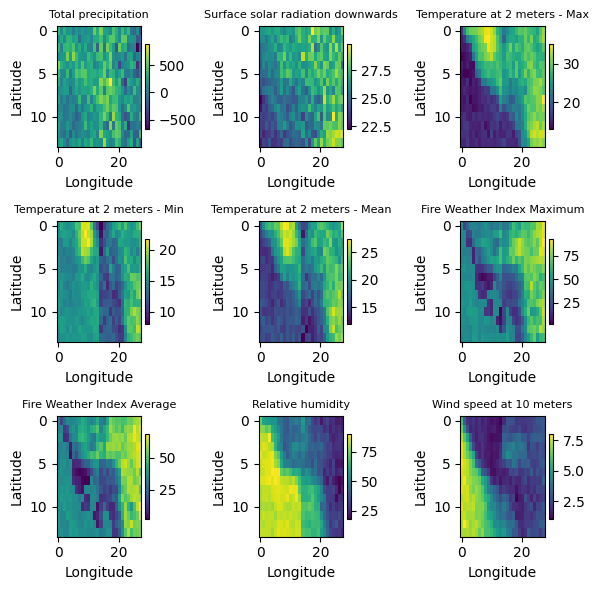

In [ ]:
plot_data(data_dict, full_names=full_names)

# Seasonal data

In [ ]:
dataset=xr.open_zarr('/content/drive/Shareddrives/CS269-Project/data/seasfire.zarr')
year_data = select_variable_data(dataset,
                                            vars
                                        ).sel(time=slice(str(2019) + '-07-04', str(2020) + '-11-08'),
                                              latitude=lat_range,
                                              longitude = slice(ca_long[0], ca_long[1])
                                        ).to_array("vars", ['time', 'latitude', 'longitude']
                                        ).transpose("time", "vars", ...
                                        )
year_data.shape

(63, 9, 20, 29)

In [ ]:
year_data.shape

(63, 9, 20, 29)

In [ ]:
# 22 timesteps from june 27
# input shape: B x T x Vi x H x W
# long_range = slice(na_long[0] + 180, na_long[1] + 180)
test_in = np.empty((29, time_history, len(vars), 20, 29))
test_out = np.empty((29, time_history, len(vars), 20, 29))
year_data = select_variable_data(dataset,
                                            vars
                                        ).sel(time=slice(str(2019) + '-07-04', str(2020) + '-11-08'),
                                              latitude=lat_range,
                                              longitude=long_range
                                        ).to_array("vars", ['time', 'latitude', 'longitude']
                                        ).transpose("time", "vars", ...
                                        )
for start in range(29):
  test_in[start] = year_data.isel(time=slice(start, start + time_history)).to_numpy()
  test_out[start][0] = year_data.isel(time=slice(start+time_history+lead_time, start+time_history+lead_time + 1)).to_numpy()

print(test_in.shape)
print(test_out.shape)


datamodule.test_dataset = torch.stack((torch.from_numpy(test_in.copy()), torch.from_numpy(test_out)), dim=1)

(29, 11, 9, 20, 29)
(29, 11, 9, 20, 29)


In [ ]:
stacked_test = torch.stack((torch.from_numpy(test_in.copy()), torch.from_numpy(test_out)), dim=1)
print(stacked_test.shape)
datamodule.test_dataset = stacked_test

torch.Size([29, 2, 11, 9, 20, 29])


In [ ]:
datamodule.test_dataset = datamodule.normalize_data(datamodule.test_dataset, datamodule.data_mean, datamodule.data_std)
torch.isnan(datamodule.test_dataset).any()

tensor(False)

In [ ]:
test_dataloader = datamodule.test_dataloader(batch_size=1)
print(len(test_dataloader))
net.to(device).half()
out_preds = np.empty((29, len(vars), 14, 28))

with torch.no_grad():
  for i, batch in enumerate(test_dataloader):
    x, y, lead_times, variables, out_variables, region_info = batch
    x, y, lead_times = x.to(device), y.to(device), lead_times.to(device)
    loss, preds = net.forward(x, y, lead_times, variables, out_variables, metric=None, lat=model.lat, region_info=region_info)
    preds = datamodule.reconstruct_data(preds.cpu())
    this_pred = preds[0, 0]
    print(torch.isnan(this_pred).all())
    print(this_pred.shape,'here', i)
    out_preds[i] = this_pred.numpy()
    print(this_pred.shape)
    print('input X shape:', x.shape, 'Y:', y.shape ,'Pred:', preds.shape)
    # break

In [ ]:
out_preds.shape

(29, 9, 14, 28)

In [ ]:
seasonalprediction = np.mean(out_preds[:3], axis=0)
seasonalprediction.shape

(9, 14, 28)

In [ ]:
seasonalprediction.shape

(9, 14, 28)

tp {'tp': 'Total precipitation', 'ssrd': 'Surface solar radiation downwards', 't2m_max': 'Temperature at 2 meters - Max', 't2m_min': 'Temperature at 2 meters - Min', 't2m_mean': 'Temperature at 2 meters - Mean', 'fwi_max': 'Fire Weather Index Maximum', 'fwi_mean': 'Fire Weather Index Average', 'rel_hum': 'Relative humidity', 'ws10': 'Wind speed at 10 meters', 'diurnal_shift': 'diurnal_shift', 'total_degree_days': 'total_degree_days'}
ssrd {'tp': 'Total precipitation', 'ssrd': 'Surface solar radiation downwards', 't2m_max': 'Temperature at 2 meters - Max', 't2m_min': 'Temperature at 2 meters - Min', 't2m_mean': 'Temperature at 2 meters - Mean', 'fwi_max': 'Fire Weather Index Maximum', 'fwi_mean': 'Fire Weather Index Average', 'rel_hum': 'Relative humidity', 'ws10': 'Wind speed at 10 meters', 'diurnal_shift': 'diurnal_shift', 'total_degree_days': 'total_degree_days'}
t2m_max {'tp': 'Total precipitation', 'ssrd': 'Surface solar radiation downwards', 't2m_max': 'Temperature at 2 meters - M

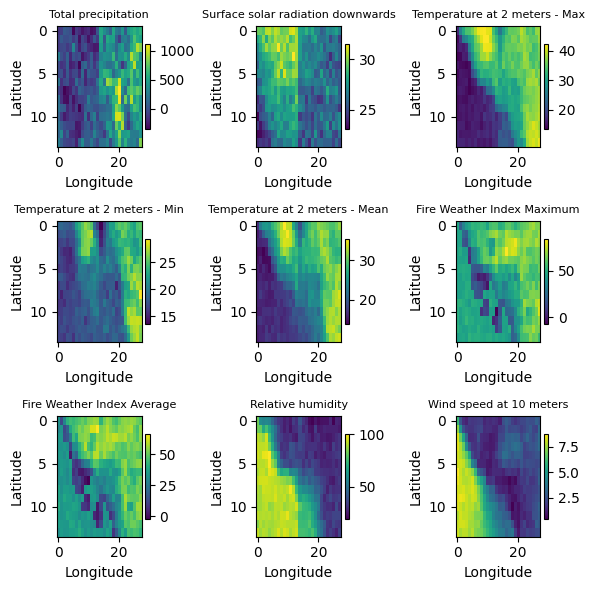

[[ 2.56326393  0.88379898 -0.37399415 -0.64288632 -0.84066651 -0.48732887
  -2.27290622  0.94046634  3.63411033  0.77046427  0.81046475  2.36326149
   0.7360194  -0.37732752  1.83603283  1.91103374  3.01715836 -0.21732557
   2.54048587  4.21418686  7.3090163   3.14771551  5.91920767  3.13215976
   2.46715164  3.02354732  1.46047269  8.36055692]
 [ 1.37936059  3.3838295  -0.50066236  0.93713297 -1.54956405 -1.71734388
  -2.29290646 -2.6862446  -0.1873252   0.71157466  0.84713187  0.35490364
   3.04104754  1.18269152  0.44268249 -1.12178105  1.98047904  5.15551779
   3.0032693   4.91704266  8.58000404  4.38092501  4.63030305  4.99982145
   2.68215427  2.60770892  2.63548703  3.96772552]
 [ 2.00047928  0.92602172 -0.06510149 -0.46510637 -0.58510784 -0.45843962
  -2.67957785 -2.52179814 -0.889556    0.37823726  0.93046622 -0.7228873
   1.72769817  0.61601794 -0.16510271  1.05380106  4.4399535   4.1354359
   1.45936156  7.78971662  5.72043571  9.51945995  0.89046573 -1.13067005
   1.5249179

In [ ]:
data = seasonalprediction
data_dict = {}
full_names = {
    'tp': 'Total precipitation',
    'ssrd': 'Surface solar radiation downwards',
    't2m_max': 'Temperature at 2 meters - Max',
    't2m_min': 'Temperature at 2 meters - Min',
    't2m_mean': 'Temperature at 2 meters - Mean',
    'fwi_max': 'Fire Weather Index Maximum',
    'fwi_mean': 'Fire Weather Index Average',
    'rel_hum': 'Relative humidity',
    'ws10': 'Wind speed at 10 meters',
    'diurnal_shift': 'diurnal_shift',
    'total_degree_days': 'total_degree_days'
}
# Loop through each variable and its index
for i, var in enumerate(variables):
    # Check if the variable is a temperature variable
    if 't2m' in var:
        # Convert from Kelvin to Celsius
        data_dict[var] = data[i, :, :] - 273.15
    else:
        # Assign the data as is for non-temperature variables
        data_dict[var] = data[i, :, :]
# Now 'data_dict' is your desired dictionary
# Calculate Diurnal shift = t2m_max - t2m_min
diurnal_shift = data_dict['t2m_max'] - data_dict['t2m_min']

# Add Diurnal shift to the dictionary
data_dict['diurnal_shift'] = diurnal_shift
plot_data(data_dict, full_names=full_names)
season_dict = data_dict
season_dict['total_degree_days'] = 29 * 5 * (1.8 * season_dict['t2m_mean']  + 32 - 50)
print(season_dict['tp'])

In [ ]:
print(datamodule.data_mean)

tensor([  5.5183,  20.6852, 294.7600, 285.3350, 289.7018,  45.5794,  33.7238,
         48.7626,   3.0729], dtype=torch.float64)


In [ ]:
y.shape

torch.Size([2, 9, 20, 29])

In [ ]:
y[ 0, :, :14, :28].shape

torch.Size([9, 14, 28])

IndexError: ignored

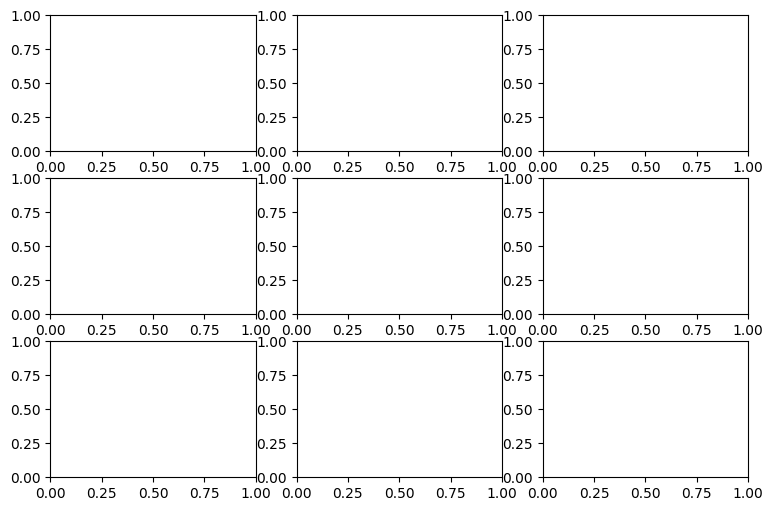

In [ ]:
plot_data(y[ 0, :, :14, :28].cpu().numpy())

# Other threshold

In [ ]:
test_dataloader = datamodule.test_dataloader()
net.to(device).half()

with torch.no_grad():
  for batch in test_dataloader:
    x, y, lead_times, variables, out_variables, region_info = batch
    x, y, lead_times = x.to(device), y.to(device), lead_times.to(device)
    print(region_info)
    loss, preds = net.forward(x, y, lead_times, variables, out_variables, metric=None, lat=model.lat, region_info=region_info)
    preds = datamodule.reconstruct_data(preds.cpu())
    this_pred = preds[0, 0, 0]
    print(this_pred.shape)
    print('input X shape:', x.shape, 'Y:', y.shape ,'Pred:', preds.shape)
    break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'patch_ids': [1, 2], 'min_h': 0, 'max_h': 13, 'min_w': 0, 'max_w': 27}
torch.Size([9, 14, 28])
input X shape: torch.Size([2, 11, 9, 20, 29]) Y: torch.Size([2, 9, 20, 29]) Pred: torch.Size([1, 1, 2, 9, 14, 28])


In [ ]:
import matplotlib.pyplot as plt
import torch


def plot_data(data_dict, variable_names=None, full_names=None):
    if variable_names is None:
        variable_names = ['tp', 'ssrd', 't2m_max', 't2m_min', 't2m_mean', 'fwi_max', 'fwi_mean', 'rel_hum', 'ws10']

    # Create subplots
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))
    axes = axes.flatten()  # Flatten the array of axes

    # Plot each variable and add individual colorbars
    for i, var_name in enumerate(variable_names):

        # Retrieve the data for the current variable from the dictionary
        var_data = data_dict[var_name]
        var_data = np.flip(var_data, axis=0)

        # Convert 'tp' from meters to centimeters, no need to transpose
        if var_name == 'tp':
            plot_data = var_data * 100
        else:
            plot_data = var_data

        # Plot the data
        im = axes[i].imshow(plot_data, cmap='viridis', aspect='auto')
        axes[i].set_title(full_names[var_name],fontsize=8)
        axes[i].set_xlabel('Longitude')
        axes[i].set_ylabel('Latitude')
        fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)  # Add colorbar for each subplot

    # Remove any unused subplots
    if len(variable_names) < len(axes):
        for ax in axes[len(variable_names):]:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_data_threshold(data, variable_names=None, thresholds=None):

    if thresholds is None:
        thresholds = {
            'tp': {'lower': 0.0, 'upper': 5.0},
            'ssrd': {'lower': 0.0, 'upper': 500.0},
            't2m_max': {'lower': 0.0, 'upper': 30.0},
            't2m_min': {'lower': -10.0, 'upper': 10.0},
            't2m_mean': {'lower': 0.0, 'upper': 15.0},
            'fwi_max': {'lower': 0.0, 'upper': 10.0},
            'fwi_mean': {'lower': 0.0, 'upper': 5.0},
            'rel_hum': {'lower': 0.0, 'upper': 60.0},
            'ws10': {'lower': 0.0, 'upper': 5.0},
            'degree_days': {},
            'diurnal_shift': {'lower': -10.0, 'upper': 20.0}
        }

    # Create subplots
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14, 12))
    axes = axes.flatten()  # Flatten the array of axes

    # Plot each variable and add individual colorbars
    for i, var_name in enumerate(variable_names):
        variable_data = data[var_name]
        variable_data = np.flip(variable_data, axis=0)

        degree_days = 50 - variable_data
        lower_threshold = thresholds[var_name]['lower']
        upper_threshold = thresholds[var_name]['upper']

        # Apply color based on both lower and upper thresholds
        im = axes[i].imshow(np.where((variable_data >= lower_threshold) & (variable_data <= upper_threshold), variable_data, np.nan), cmap='viridis', aspect='auto', vmin=lower_threshold, vmax=upper_threshold)
        axes[i].set_title(full_names[var_name],fontsize=10)
        axes[i].set_xlabel('Longitude')
        axes[i].set_ylabel('Latitude')
        fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)  # Add colorbar for each subplot

    # Remove any unused subplots
    if len(variable_names) < len(axes):
        for ax in axes[len(variable_names):]:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def create_custom_colormap(lower_threshold, upper_threshold, min_val, max_val):
    """
    Create a custom colormap where values within the thresholds use the 'viridis' colormap,
    and values outside the thresholds are red.
    """
    # Normalize threshold positions within the data range
    lower_pos = np.clip((lower_threshold - min_val) / (max_val - min_val), 0, 1)
    upper_pos = np.clip((upper_threshold - min_val) / (max_val - min_val), 0, 1)

    # Define the colors and nodes for the colormap
    colors = ['red', cm.viridis(0), cm.viridis(1), 'red']
    nodes = [0.0, lower_pos, upper_pos, 1.0]
    cmap = mcolors.LinearSegmentedColormap.from_list("", list(zip(nodes, colors)))

    return cmap
def plot_data_threshold(data, variable_names=None, thresholds=None):

    if thresholds is None:
        # Default thresholds (you can customize these)
        thresholds = {
            'tp': {'lower': 0.0, 'upper': 5.0},
            'ssrd': {'lower': 0.0, 'upper': 500.0},
            't2m_max': {'lower': 0.0, 'upper': 30.0},
            't2m_min': {'lower': -10.0, 'upper': 10.0},
            't2m_mean': {'lower': 0.0, 'upper': 15.0},
            'fwi_max': {'lower': -20.0, 'upper': 50.0},
            'fwi_mean': {'lower': -10.0, 'upper': 50.0},
            'rel_hum': {'lower': 0.0, 'upper': 60.0},
            'ws10': {'lower': 0.0, 'upper': 5.0},
            'degree_days': {},
            'diurnal_shift': {'lower': 0.0, 'upper': 20.0}
        }

    # Create subplots
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14, 12))
    axes = axes.flatten()  # Flatten the array of axes

    # Plot each variable and add individual colorbars
    for i, var_name in enumerate(variable_names):
        variable_data = data[var_name]
        variable_data = np.flip(variable_data, axis=0)
        min_val, max_val = np.min(variable_data), np.max(variable_data)
        lower_threshold = thresholds[var_name]['lower']
        upper_threshold = thresholds[var_name]['upper']

        degree_days = 50 - variable_data
        # Create custom colormap
        custom_cmap = create_custom_colormap(lower_threshold, upper_threshold, min_val, max_val)

        # Apply color based on both lower and upper thresholds
        im = axes[i].imshow(variable_data, cmap=custom_cmap, aspect='auto', vmin=min_val, vmax=max_val)

        axes[i].set_title(full_names[var_name],fontsize=10)
        axes[i].set_xlabel('Longitude')
        axes[i].set_ylabel('Latitude')
        fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)  # Add colorbar for each subplot

    # Remove any unused subplots
    if len(variable_names) < len(axes):
        for ax in axes[len(variable_names):]:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


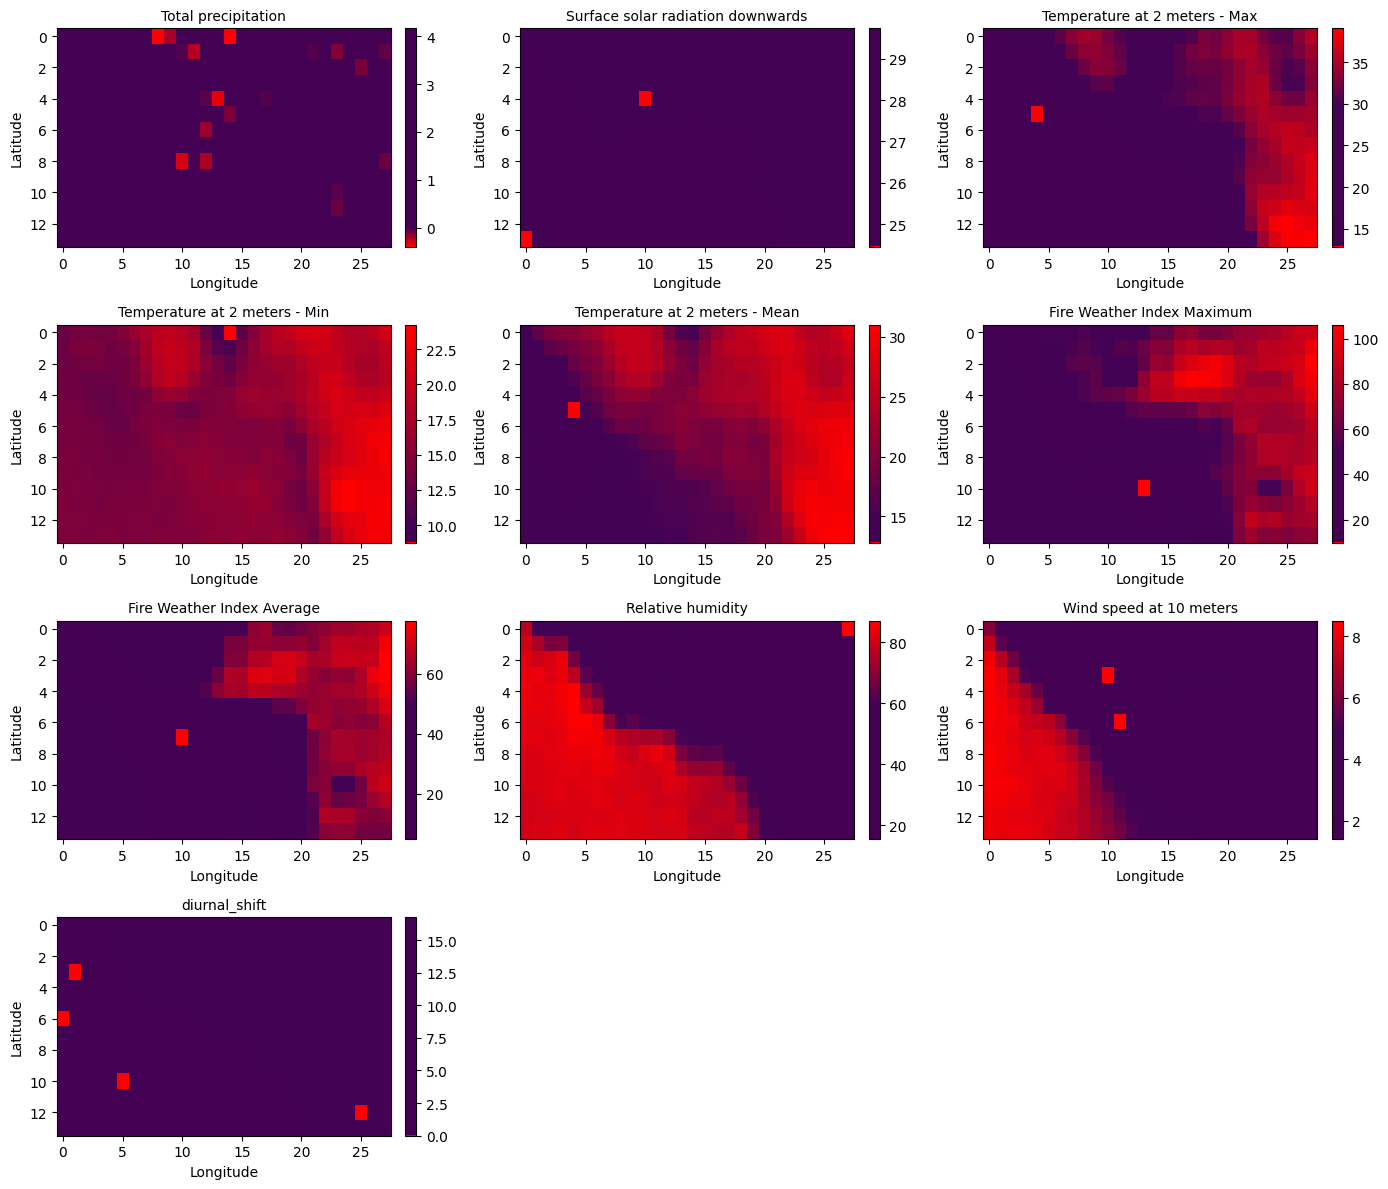

In [ ]:
variable_names = ['tp', 'ssrd', 't2m_max', 't2m_min', 't2m_mean', 'fwi_max', 'fwi_mean', 'rel_hum', 'ws10', 'diurnal_shift']
plot_data_threshold(data_dict, variable_names)

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_data_threshold(data, variable_names=None, thresholds=None):

    if thresholds is None:
        thresholds = {
            'tp': {'lower': 0.0, 'upper': 85.0},
            'ssrd': {'lower': 0.0, 'upper': 500.0},
            't2m_max': {'lower': 0.0, 'upper': 30.0},
            't2m_min': {'lower': -10.0, 'upper': 10.0},
            't2m_mean': {'lower': 16.0, 'upper': 18.5},
            'fwi_max': {'lower': -10.0, 'upper': 50.0},
            'fwi_mean': {'lower': 0.0, 'upper': 50.0},
            'rel_hum': {'lower': 0.0, 'upper': 60.0},
            'ws10': {'lower': 0.0, 'upper': 20.0},
            'degree_days': {},
            'diurnal_shift': {'lower': 10.0, 'upper': 20.0},
            'total_degree_days': {'lower': 3000.0, 'upper': 3500.0},
        }

    # Create subplots
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8))
    axes = axes.flatten()  # Flatten the array of axes

    # Plot each variable and add individual colorbars
    for i, var_name in enumerate(variable_names):
        variable_data = data[var_name]
        if var_name == 'ws10':
          variable_data = variable_data * 2.53
        variable_data = np.flip(variable_data, axis=0)
        lower_threshold = thresholds[var_name]['lower']
        upper_threshold = thresholds[var_name]['upper']

        # Original data plot
        im = axes[i].imshow(variable_data, cmap='viridis', aspect='auto', vmin=lower_threshold, vmax=upper_threshold)

        # Create a masked array for out-of-threshold values
        mask = np.ma.masked_inside(variable_data, lower_threshold, upper_threshold)

        # Overlay the masked array with red color for out-of-threshold points
        axes[i].imshow(mask, cmap='Reds', interpolation='none', alpha=0.7)

        # Setting titles and labels
        axes[i].set_title(full_names[var_name], fontsize=10)
        axes[i].set_xlabel('Longitude', fontsize=10)
        axes[i].set_ylabel('Latitude', fontsize=10)

        # Add colorbar for each subplot
        fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

    # Remove any unused subplots
    if len(variable_names) < len(axes):
        for ax in axes[len(variable_names):]:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
season_dict['ws10']

array([[8.16898164, 7.6853349 , 7.92781719, 7.90277826, 7.52455859,
        7.85006471, 7.19971139, 7.03893509, 6.93087233, 6.46501641,
        5.94183451, 5.45093965, 5.07140215, 4.51494482, 3.95173358,
        3.81780824, 3.11708877, 3.48064748, 3.67070451, 1.87333747,
        0.97786618, 1.76560417, 1.72343333, 2.14860099, 1.92934561,
        2.03724364, 2.26358241, 2.37938747],
       [8.03192643, 8.20719896, 8.2019276 , 8.07936862, 7.62735   ,
        7.6102181 , 7.32358822, 7.38618555, 6.76548359, 6.11513027,
        5.70989492, 5.33167526, 4.52285186, 4.12453516, 3.69310776,
        3.19068182, 3.41236697, 3.3928156 , 2.44470284, 1.17224736,
        0.77327174, 1.61866517, 2.07397839, 1.36234557, 1.58473083,
        1.72606901, 2.99723754, 2.74829989],
       [7.77494792, 8.22960221, 7.97130586, 8.00952318, 7.75518034,
        7.65897812, 7.12195892, 7.08901296, 7.01982643, 5.99718372,
        5.32179147, 5.1313638 , 4.1225584 , 3.61494347, 3.47830008,
        2.98115723, 2.8912

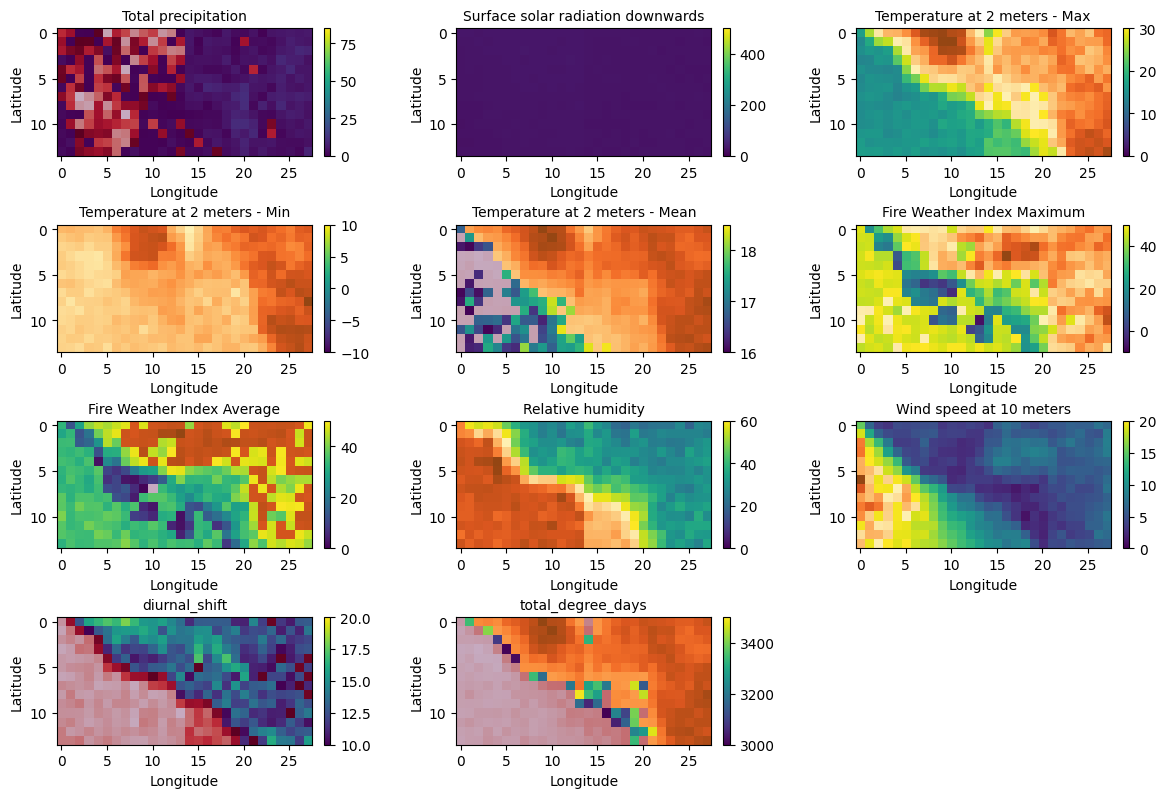

In [ ]:
variable_names = ['tp', 'ssrd', 't2m_max', 't2m_min', 't2m_mean', 'fwi_max', 'fwi_mean', 'rel_hum', 'ws10', 'diurnal_shift', 'total_degree_days']
plot_data_threshold(season_dict, variable_names)